# Homework 1 : Convection of a gaussian function

In [1]:
import math as mt
import numpy as np

from math import pi as π
from numpy.fft import fft,fftshift,ifft

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML,Image
nfig = 1

In [2]:
def dft(func, start,end,N, order=1):
    """
    Return the 1D-derivative of function 'func', at specified order
    """
    L = end-start
    h = L/N
    x = np.arange(start,end, step=h)

    # -- Compute the FFT
    u = func(x)
    u_hat = fftshift(fft(u))
    k = np.arange(-N/2,N/2)

    # -- Compute the Derivative
    u_dot_hat = (1j*k)**order * u_hat
    u_dot = ifft(fftshift(u_dot_hat)).real

    return x, u_dot

def gaussian(x, μ=0,σ=1):
    """
    Gaussian function
    """
    u = 1/mt.sqrt(2*π*σ**2) * np.exp(-(x-μ)**2/(2*σ**2))
    return u

def dgaussian(x, μ=0,σ=1):
    """
    Derivative of the gaussian function
    """
    u_dot = -2*(x-μ)/(2*σ**2) * gaussian(x, μ=μ,σ=σ)
    return u_dot

First, one discretises the gaussian functions. The bounds of the domain are $0$ and $2\pi$, and the amount of sample points is $N=2^m$. In order to know the right value for $m$, we decide to study the evolution of the error between the spectral method of derivation and the analytical solution.

We observe n figures below that the error stabilizes starting from $m=5$. Since the bell shape of the gaussian for $N=2^5$ sample points remains quite sharp, one decides to take more points whatever the spectral method performing well. We decide $m=8$.

In [3]:
m = np.arange(2,15)
Nvec = 2**m
error = np.empty(m.shape)

μ = π
σ = 0.5
f = lambda x: gaussian(x, μ=μ,σ=σ)

for (i,N) in enumerate(Nvec):
    x,u_dot = dft(f, 0,2*π,N, order=1)
    uprime  = -2*(x-μ)/(2*σ**2) * f(x)
    error[i] = np.abs(uprime-u_dot).max()

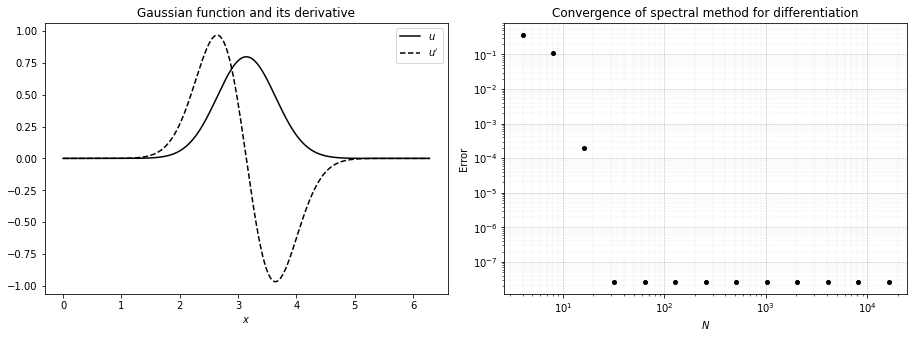

In [4]:
fig = plt.figure(nfig, figsize=(6.4*2,4.8))

ax1 = fig.add_subplot(121)
ax1.plot(x,f(x), 'k-', label=r'$u$')
ax1.plot(x,uprime, 'k--', label=r"$u'$")
ax1.set_xlabel(r'$x$')
ax1.set_title('Gaussian function and its derivative')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.loglog(Nvec,error, 'k-o', markersize=4, lw=0)
ax2.set_xlabel(r'$N$')
ax2.set_ylabel('Error')
ax2.set_title('Convergence of spectral method for differentiation')
ax2.grid(which='major', linestyle='--', linewidth=0.5)
ax2.grid(which='minor', linestyle=':', linewidth=0.25)

plt.tight_layout()
nfig += 1

One may also study the effect of the standard deviation of the function on the spectral method of differentiation. We observe the consequence of it on the figure below. We observe that there the curve has a minimum which means that there exists a value for $\sigma$ such that the error is minimal.

But this range gets wider while the domain gets larger. Indeed, when the gaussian is larger, its values at the bounds are no more equal to $0$ and the function cannot be considered as periodic anymore. It has for consequence to keep $\sigma$ at moderate values.

On the other side, we observe that while $\sigma$ is getting smaller, the error becomes much more important. The error is now coming from the fact that the gaussian is getting sharper, it means $$\lim_{\sigma\to0} \mathcal{N}_{0,\sigma}(x) = \delta(x).$$ In that respect, the function is not continuous anymore which means it is not derivable neither.

For further computations, we fix $\sigma = 0.5$.

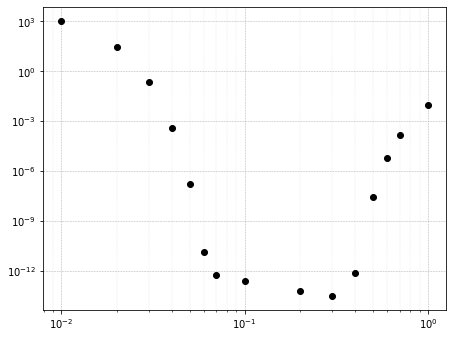

In [5]:
N = 2**8
x = np.arange(0,2*π, step=2*π/N)

μ = π
σ = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,\
     0.1,0.2,0.3,0.4,0.5,0.6,0.7,1]
error = np.empty(len(σ))

for (i,s) in enumerate(σ):
    f = lambda x: gaussian(x, μ=μ,σ=s)
    x,u_dot = dft(f, 0,2*π,N, order=1)
    uprime  = -2*(x-μ)/(2*s**2) * f(x)
    error[i] = np.abs(uprime-u_dot).max()
        
fig = plt.figure(nfig, figsize=(6.4,4.8))
plt.loglog(σ,error, 'k-o', lw=0)
plt.grid(which='major', linestyle='--', linewidth=0.5)
plt.grid(which='minor', linestyle=':', linewidth=0.25)
plt.tight_layout()
nfig += 1

Finally, we simulate the wave propagation described by $$\frac{\partial u}{\partial t} + c(x) \frac{\partial u}{\partial x} = 0, \qquad c(x) = \frac{1}{5} + \sin^2(x-1), \qquad u(x,0) = \mathcal{N}(\pi,0.5)$$ using finite differences in the time domain and spectral derivation in the space domain.

In [6]:
N = 2**8
h = 2*π/N
x = np.arange(0,2*π, step=h)

μ = π
σ = 0.5
u = gaussian(x, μ=μ,σ=σ)

k = np.arange(-N/2,N/2)
c = 0.2 + np.power(np.sin(x-1),2)
dt = h/c.max()/5

tmax = 4*π
Ntime = int(tmax/dt)
dt = tmax/Ntime
Nplots = 100

In [7]:
data = np.zeros((Nplots,N))
data[0,:] = u; u_old = u
time = np.arange(Nplots)/Nplots * tmax
i = 0
for n in range(Ntime):
    u_hat = fftshift(fft(u))
    u_dot_hat = (1j*k) * u_hat
    u_dot = ifft(fftshift(u_dot_hat)).real

    u_new = u_old - 2*dt*c*u_dot if i>0 else u_old - dt*c*u_dot
    u_old = u
    u = u_new

    if n%(Ntime//Nplots+1)==0:
        data[i,:] = u_old
        i += 1

In [8]:
fig = plt.figure(nfig)
u_plt, = plt.plot([], [], 'k-')
u_txt  = plt.text(π, 0.9, '', ha='center', fontsize=10)
tplot  = dt*Ntime/Nplots

plt.xlim([x[0],x[-1]])
plt.ylim([0,1])
plt.xlabel(r'$x$', fontsize=10)
plt.ylabel(r'$u$', fontsize=10)
# plt.title(r'$u_t + c(x) u_x = 0 \qquad u^0 = \mathcal{N}(\pi,0.5)$', fontsize=12)
plt.title(r'Convection of a Gaussian Function', fontsize=12)
plt.tight_layout()

def animate(t):
    u_plt.set_data(x, data[t,:])
    u_txt.set_text('Current time : t = %.2f [s]' %(time[t]))
    return u_plt,u_txt,

anim = animation.FuncAnimation(fig, animate, frames=Nplots, interval=1000*tplot, blit=True)
plt.close(anim._fig)

nfig += 1

In [9]:
HTML(anim.to_html5_video())
rc('animation', html='html5')

In [10]:
anim

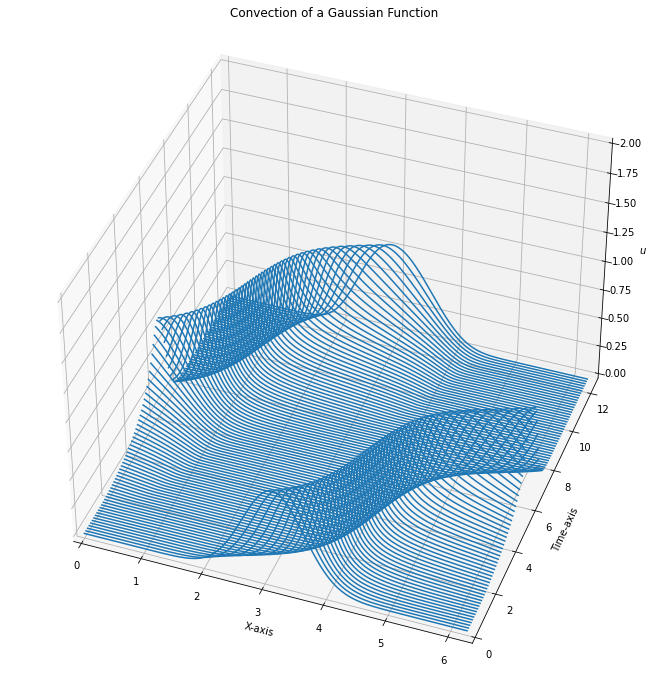

In [11]:
fig = plt.figure(nfig, figsize=(9.6,9.6))
ax  = plt.axes(projection='3d')

for i in range(Nplots):
    t = time[i]*np.ones(x.shape)
    ax.plot3D(x,t, data[i,:], color='tab:blue')

ax.set_xlim([x[0],x[-1]])
ax.set_ylim([0,tmax])
ax.set_zlim([0,2])
ax.view_init(40,-70)

ax.set_xlabel('X-axis')
ax.set_ylabel('Time-axis')
ax.set_zlabel(r'$u$')
ax.set_title('Convection of a Gaussian Function', fontsize=12)

fig.tight_layout()
nfig += 1